# GNN for Link + Vote Prediction

This notebook trains a **Graph Neural Network (GraphSAGE)** to predict, for a pair *(voter u, candidate t)*:

- **Link existence**: will *u* vote on *t*? (`NoVote` vs `Voted`)
- **Vote polarity** (if voted): `Oppose`, `Neutral`, or `Support`

We output a 4-class prediction, but train hierarchically with two heads: link existence and vote polarity.

Key implementation choices:
- **No leakage**: message passing uses only **training positive edges**.
- **Mini-batch training** with **LinkNeighborLoader**: each batch samples a subgraph around the queried links.
- **Negative sampling**: we create `NoVote` examples by sampling users who did **not** vote for the same candidate.

## Setup

In [ ]:
# Import standard libraries
import sys
from pathlib import Path
# Plotting
import seaborn as sns
import matplotlib.pyplot as plt
# Data handling
import pandas as pd
# Computations
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import Data, HeteroData
from torch_geometric.nn import SAGEConv, to_hetero
from torch_geometric.loader import LinkNeighborLoader
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

# Import this project modules
REPO_ROOT = Path('.').resolve()
if REPO_ROOT not in sys.path:
    sys.path.insert(0, str(REPO_ROOT))
from dataset import WikiRfAPreprocessor, CandidateCentricSampler, train_val_test_split_by_date, extract_node_features
from utility import analyze_split_statistics, plot_cm
from training import eval_hierarchical, train_hierarchical

# Device
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

CHECKPOINT_PATH = "checkpoints/hiergnn.pt"

print("DEVICE:", DEVICE)

DEVICE: cpu


## Data loading and filtering

Load and parse the wiki-RfA dataset from the .txt.gz file into (SRC, TGT, VOT, DAT) tuples.

Invalid samples are filtered out:

- empty date
- incorrect date
- self votes

In [2]:
preprocessed_RfA = WikiRfAPreprocessor("dataset/wiki-RfA.txt.gz")
preprocessed_RfA.load(verbose=True)

Loading dataset from dataset/wiki-RfA.txt.gz...
Raw line 0: SRC:Steel1943
Raw line 1: TGT:BDD
Raw line 2: VOT:1
Raw line 3: RES:1
Raw line 4: YEA:2013
Raw line 5: DAT:23:13, 19 April 2013
Raw line 6: TXT:'''Support''' as co-nom.
Raw line 7: 
Raw line 8: SRC:Cuchullain
Raw line 9: TGT:BDD

------- Dataset Loaded -------
Total valid samples loaded: 188816
Example sample (SRC, TGT, VOT, DATE): ('Steel1943', 'BDD', 1, 20130419)

Discarded edges breakdown:
  EMPTY_ERROR: 9367
    Skipped edge: ('', 'Jason Quinn', '')
    Skipped edge: ('', 'Jason Quinn', '')
    Skipped edge: ('', 'Legoktm', '')
    Skipped edge: ('Majoreditor', 'Lord Roem', '')
  SELF_LOOP: 88
    Skipped edge: ('Ryan Vesey', 'Ryan Vesey', '17:07, 4 July 2012')
    Skipped edge: ('Anomie', 'Anomie', '16:29, 25 September 2011')
    Skipped edge: ('Spongefrog', 'Spongefrog', '18:33, 28 September 2011')
    Skipped edge: ('Tarheel95', 'Tarheel95', '00:46, 8 December 2011')
  ERROR_OTHERS: 4
    Skipped edge: ('JonasEncycloped

## User encoding

Encode Wikipedia usernames into contiguous integer node IDs.

In [3]:
# Encode users as numerical IDs
users = sorted(set([s[0] for s in preprocessed_RfA.samples] + [s[1] for s in preprocessed_RfA.samples]))
encoder = LabelEncoder()
user_ids = encoder.fit_transform(users)
user_map = dict(zip(users, user_ids))

print(f"Unique users: {len(users)}")
print(list(user_map.items())[:10])

Unique users: 11128
[('!---slappdash---!', np.int64(0)), ('%D0%90', np.int64(1)), ("'sed", np.int64(2)), ('(.Y.)', np.int64(3)), ('(:Julien:)', np.int64(4)), ('(aeropagitica)', np.int64(5)), ('*Kat*', np.int64(6)), ('*Spark*', np.int64(7)), ('*drew', np.int64(8)), ('-Midorihana-', np.int64(9))]


In [4]:
# Dataset build (edge list + label)
X = []
y = []
dates = []

for src, tgt, vot, dat in preprocessed_RfA.samples:
    X.append([user_map[src], user_map[tgt]])
    y.append(vot)
    dates.append(dat)
        
X = torch.tensor(X, dtype=torch.long)
y = torch.tensor(y, dtype=torch.long)
dates = np.array(dates)

# labels for positives: {-1,0,1} -> {1,2,3}
y_pos = y + 2
print("Positive edges:", X.size(0))

Positive edges: 188816


## Train - Validation - Test split

This function divide the whole dataset in three parts based on the date. The outputs are ordered by date.

Training set shape: torch.Size([183356, 2]) between dates 20030816 and 20121004
Validation set shape: torch.Size([1621, 2]) between dates 20121005 and 20121204
Test set shape: torch.Size([3839, 2]) between dates 20121212 and 20130605

===================== DATASET SPLITTING ANALYSIS =====================

[1] Topology & Density (Graph Connectivity)
        Edges  Nodes Avg Degree
Split                          
Train  175446  10874      16.13
Val      1619    486       3.33
Test     3837    831       4.62

[2] User Overlap & Cold Start Diagnostics (Inductive vs Transductive)


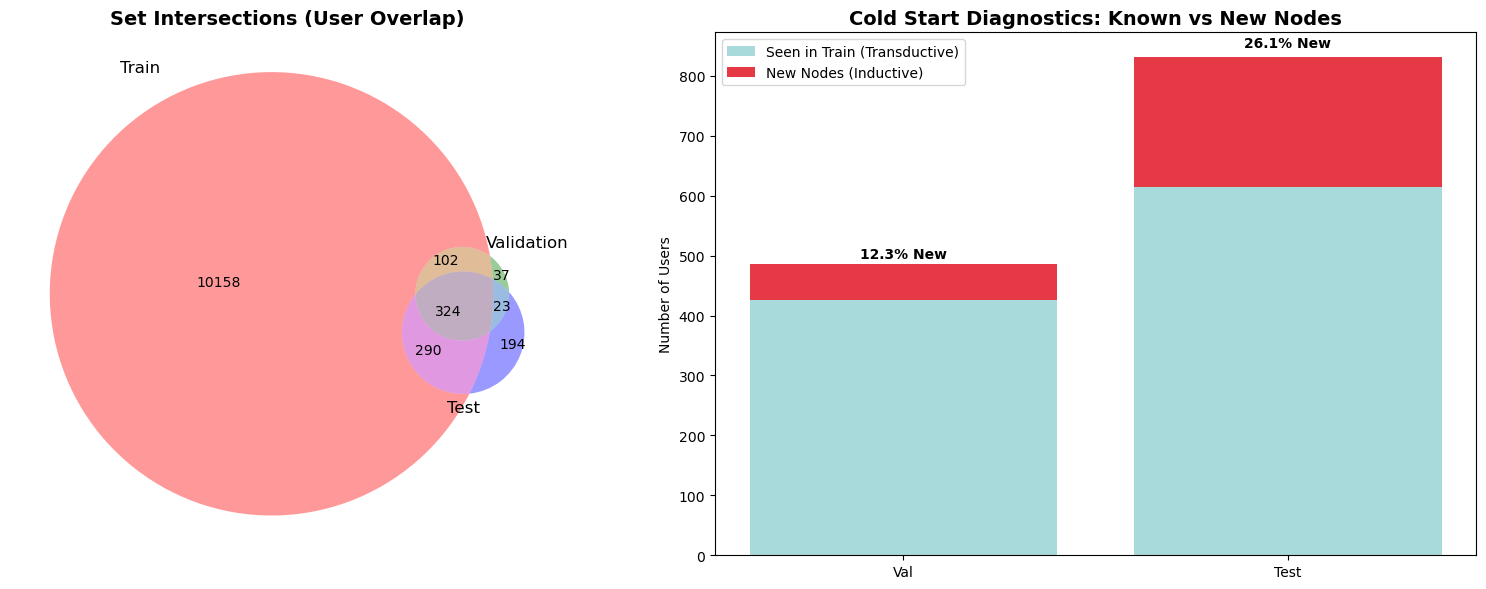


[3] Edge Duplicates Analysis
Found 19 duplicate edges between Train-Val
Found 102 duplicate edges between Train-Test
Found 0 duplicate edges between Val-Test

[4] Class Distribution Analysis (Vote Polarity)


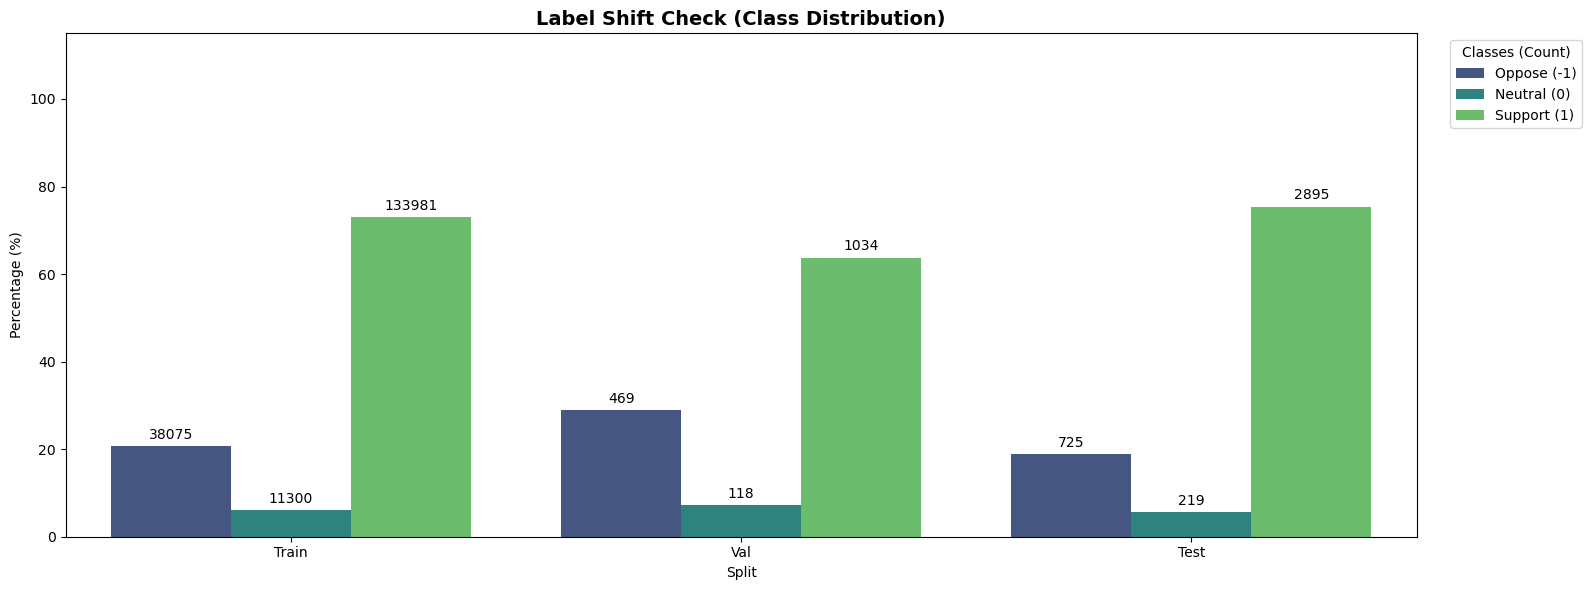

In [5]:
(X_tr_pos, y_tr_pos, dates_tr), (X_val_pos, y_val_pos, dates_val), (X_test_pos, y_test_pos, dates_test) = train_val_test_split_by_date(X, y_pos, dates, val_months=2, test_months=6)


# Splits summary
print(f"Training set shape: {X_tr_pos.shape} between dates {dates_tr.min()} and {dates_tr.max()}")
print(f"Validation set shape: {X_val_pos.shape} between dates {dates_val.min()} and {dates_val.max()}")
print(f"Test set shape: {X_test_pos.shape} between dates {dates_test.min()} and {dates_test.max()}")

analyze_split_statistics(X_tr_pos, y_tr_pos-1, X_val_pos, y_val_pos-1, X_test_pos, y_test_pos-1)

## Data structure creation

In [6]:
num_users = len(user_map)

# Message-passing graph 
edge_index = X_tr_pos.t().contiguous()  # [2, E_train_pos]

# Filling features
x_features = torch.zeros((num_users, 0), dtype=torch.float)

# HeteroData
data = HeteroData()
data['user'].x = x_features

data['user', 'votes', 'user'].edge_index = edge_index
data['user', 'rev_votes', 'user'].edge_index = edge_index.flip(0)

data = data.to(DEVICE)

print(data)

HeteroData(
  user={ x=[11128, 0] },
  (user, votes, user)={ edge_index=[2, 183356] },
  (user, rev_votes, user)={ edge_index=[2, 183356] }
)


## Negative sampling

**Metodologia:**
Per ogni arco positivo reale $(u, t)$ nel training set, generiamo $k$ archi negativi $(u', t)$ dove $u'$ è un utente casuale che non ha **mai** votato per il candidato $t$.
La verifica viene effettuata contro una **Global Forbidden Map** che contiene l'unione di tutti gli archi positivi presenti in Train, Validation e Test set.

**Perché questa scelta è superiore al Random Sampling:**
1.  **Candidate-Centric:** Mantenendo fisso il candidato target $t$ e variando solo il votante, preserviamo la distribuzione di popolarità dei candidati (il *degree distribution*). I candidati che ricevono molti voti avranno proporzionalmente più esempi negativi, costringendo il modello a imparare caratteristiche distintive più fini rispetto alla semplice popolarità.
2.  **Eliminazione dei Falsi Negativi (Noise Reduction):** Nel puro random sampling, c'è il rischio di selezionare come "esempio negativo" una coppia $(u, t)$ che appare nel Test set (futuro). Questo insegnerebbe alla rete che l'arco $(u, t)$ non deve esistere, introducendo *label noise* contraddittorio.

**Nota sul Data Leakage:**
L'utilizzo della *Global Forbidden Map* (che include informazioni dal Test set) **non costituisce Data Leakage dannoso**.
* **Non è Leakage:** Non stiamo usando l'informazione futura per predire l'etichetta positiva (non diciamo al modello "questo arco esiste").
* **È Noise Filtering:** Stiamo usando l'informazione futura solo per *escludere* un dato dal training set dei negativi. Garantiamo che i negativi siano **Veri Negativi**, evitando di penalizzare il modello per un arco che, nella realtà storica del dataset, si verificherà successivamente.

In [7]:
neg_ratio = 1

sampler = CandidateCentricSampler([X_tr_pos, X_val_pos, X_test_pos])

# Negatives for each split (no_vote = 0)
X_tr_neg, y_tr_neg = sampler.sample_negatives(X_tr_pos, num_users, ratio=neg_ratio, seed=42)
X_val_neg, y_val_neg = sampler.sample_negatives(X_val_pos, num_users, ratio=neg_ratio, seed=123)
X_test_neg, y_test_neg = sampler.sample_negatives(X_test_pos, num_users, ratio=neg_ratio, seed=999)

# 4-class datasets: 0=no_vote, 1=oppose, 2=neutral, 3=support
X_tr_4 = torch.cat([X_tr_pos,  X_tr_neg],  dim=0)
y_tr_4 = torch.cat([y_tr_pos,  y_tr_neg],  dim=0)

X_val_4 = torch.cat([X_val_pos, X_val_neg], dim=0)
y_val_4 = torch.cat([y_val_pos, y_val_neg], dim=0)

X_test_4 = torch.cat([X_test_pos, X_test_neg], dim=0)
y_test_4 = torch.cat([y_test_pos, y_test_neg], dim=0)

print("Train 4-class size:", X_tr_4.size(0), " (pos:", X_tr_pos.size(0), "neg:", X_tr_neg.size(0), ")")
print("Val 4-class size:", X_val_4.size(0), " (pos:", X_val_pos.size(0), "neg:", X_val_neg.size(0), ")")
print("Test 4-class size:", X_test_4.size(0), " (pos:", X_test_pos.size(0), "neg:", X_test_neg.size(0), ")")

# ---- Class weights (smoothed) ----
# For hierarchical training we use:
# - link weights on {NoVote, Voted}
# - polarity weights on {Oppose, Neutral, Support} (only positives)

# Link labels derived from 4-class labels: 0 -> NoVote, {1,2,3} -> Voted
y_tr_link = (y_tr_4 != 0).long()
link_counts = torch.bincount(y_tr_link, minlength=2).float()
link_base_w = link_counts.sum() / link_counts
alpha = 0.5
link_weights = link_base_w.pow(alpha).to(DEVICE)

# Polarity labels from positives only: {1,2,3} -> {0,1,2}
y_tr_pol = (y_tr_pos - 1).long()
pol_counts = torch.bincount(y_tr_pol, minlength=3).float()
pol_base_w = pol_counts.sum() / pol_counts
pol_weights = pol_base_w.pow(alpha).to(DEVICE)

print("Train link counts [NoVote, Voted]:", link_counts.tolist())
print("Link weights:", link_weights.tolist())
print("Train polarity counts [Oppose, Neutral, Support]:", pol_counts.tolist())
print("Polarity weights:", pol_weights.tolist())

Train 4-class size: 366712  (pos: 183356 neg: 183356 )
Val 4-class size: 3242  (pos: 1621 neg: 1621 )
Test 4-class size: 7678  (pos: 3839 neg: 3839 )
Train link counts [NoVote, Voted]: [183356.0, 183356.0]
Link weights: [1.4142135381698608, 1.4142135381698608]
Train polarity counts [Oppose, Neutral, Support]: [38075.0, 11300.0, 133981.0]
Polarity weights: [2.1944596767425537, 4.028174877166748, 1.1698386669158936]


## Neighbor-sampled loaders

Create LinkNeighborLoader objects to train on mini-batches using sampled subgraphs.

In [8]:
edge_type = ('user', 'votes', 'user')

def add_edge_label_to_batch(batch):
    # Copy labels to top-level attribute for convenience
    if hasattr(batch[edge_type], 'edge_label'):
        batch.edge_label = batch[edge_type].edge_label
    return batch

train_loader = LinkNeighborLoader(
    data=data,
    num_neighbors=[100, 50],
    edge_label_index=(edge_type, X_tr_4.t().contiguous()),
    edge_label=y_tr_4,
    batch_size=2048,
    shuffle=True,
    transform=add_edge_label_to_batch
)

val_loader = LinkNeighborLoader(
    data=data,
    num_neighbors=[100, 50],
    edge_label_index=(edge_type, X_val_4.t().contiguous()),
    edge_label=y_val_4,
    batch_size=4096,
    shuffle=False,
    transform=add_edge_label_to_batch
)

test_loader = LinkNeighborLoader(
    data=data,
    num_neighbors=[100, 50],
    edge_label_index=(edge_type, X_test_4.t().contiguous()),
    edge_label=y_test_4,
    batch_size=4096,
    shuffle=False,
    transform=add_edge_label_to_batch
)

## Model

Define the hierarchical GraphSAGE model with a shared GNN encoder and two edge-level heads:
1) Link existence head: NoVote vs Voted (binary)
2) Polarity head: Oppose vs Neutral vs Support (3-class), used only when a vote exists

In [9]:
class HierGNN(nn.Module):
    def __init__(self, metadata, num_users, emb_dim=64, hidden_dim=128, dropout=0.3):
        super().__init__()

        self.node_emb = nn.Embedding(num_users, emb_dim)

        # Base Homogeneous GNN
        class BaseGNN(nn.Module):
            def __init__(self):
                super().__init__()
                self.dropout = nn.Dropout(p=dropout) 
                self.conv1 = SAGEConv(emb_dim, hidden_dim)
                self.conv2 = SAGEConv(hidden_dim, hidden_dim)
            def forward(self, x, edge_index):
                x = self.dropout(x)
                x = self.conv1(x, edge_index)
                x = F.relu(x)
                x = self.dropout(x)
                x = self.conv2(x, edge_index)
                x = F.relu(x)
                return x
        
        # Convert to Hetero GNN
        self.hetero_gnn = to_hetero(BaseGNN(), metadata, aggr='sum')

        # Edge feature dimension: [h_s, h_t, |h_s-h_t|, h_s*h_t]
        edge_in = hidden_dim * 4

        # Head 1: link existence (NoVote vs Voted)
        self.link_mlp = nn.Sequential(
            nn.Linear(edge_in, 128),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(128, 32),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(32, 2)
        )

        # Head 2: polarity (Oppose/Neutral/Support)
        self.pol_mlp = nn.Sequential(
            nn.Linear(edge_in, 128),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(128, 32),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(32, 3)
        )

    def forward(self, batch: Data):
        """
        Forward pass that returns both heads' logits for the batch edge_label_index.
        - link_logits: shape [B, 2]
        - pol_logits: shape [B, 3]
        """
        # Dict for node embeddings
        n_id = batch['user'].n_id
        x = self.node_emb(n_id) # [batch_nodes, emb_dim]

        x_dict = {'user': x}
        
        # Learn GNN embeddings
        z_dict = self.hetero_gnn(x_dict, batch.edge_index_dict)
        
        src, tgt = batch[('user', 'votes', 'user')].edge_label_index
        
        # Get user embeddings
        z = z_dict['user']
        h_src = z[src]
        h_tgt = z[tgt]
        
        # Edge features
        e = torch.cat([h_src, h_tgt, torch.abs(h_src - h_tgt), h_src * h_tgt], dim=1)
        
        # Predict
        link_logits = self.link_mlp(e)
        pol_logits = self.pol_mlp(e)
        return link_logits, pol_logits


## Training

Train the model with weighted cross-entropy and early stopping on validation macro-F1.

In [ ]:
model = HierGNN(
    metadata=data.metadata(),
    num_users=num_users,
    emb_dim=64,
    hidden_dim=128,
    dropout=0.2
).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

model = train_hierarchical(
        model, optimizer,
        train_loader, val_loader,
        device=DEVICE,
        patience=8,
        lambda_pol=1.0,
        link_weights=link_weights,
        pol_weights=pol_weights,
        num_epochs=50,
        checkpoint_path=CHECKPOINT_PATH,
    )

Epoch 00 | Loss(avg): 1.6884 | Val macro-F1(4): 0.3286 | Val link-F1: 0.6643 | Val pol-macroF1: 0.3086
Epoch 01 | Loss(avg): 1.4814 | Val macro-F1(4): 0.3425 | Val link-F1: 0.6009 | Val pol-macroF1: 0.3470
Epoch 02 | Loss(avg): 1.3306 | Val macro-F1(4): 0.3745 | Val link-F1: 0.6501 | Val pol-macroF1: 0.3842
Epoch 03 | Loss(avg): 1.2588 | Val macro-F1(4): 0.3764 | Val link-F1: 0.6181 | Val pol-macroF1: 0.4101
Epoch 04 | Loss(avg): 1.2107 | Val macro-F1(4): 0.3625 | Val link-F1: 0.6044 | Val pol-macroF1: 0.3890
Epoch 05 | Loss(avg): 1.1813 | Val macro-F1(4): 0.3694 | Val link-F1: 0.6219 | Val pol-macroF1: 0.3941
Epoch 06 | Loss(avg): 1.1517 | Val macro-F1(4): 0.3765 | Val link-F1: 0.6013 | Val pol-macroF1: 0.4210
Epoch 07 | Loss(avg): 1.1295 | Val macro-F1(4): 0.3897 | Val link-F1: 0.6782 | Val pol-macroF1: 0.3983
Epoch 08 | Loss(avg): 1.1015 | Val macro-F1(4): 0.4011 | Val link-F1: 0.6748 | Val pol-macroF1: 0.4195
Epoch 09 | Loss(avg): 1.0842 | Val macro-F1(4): 0.3835 | Val link-F1: 0.6

In [11]:
# Test evaluation
test_macro_f1_4, test_link_f1, test_pol_f1, (y_true_4, y_pred_4), pol_report = eval_hierarchical(model, test_loader, DEVICE, report=True)

print(f"Test macro-F1(4-class): {test_macro_f1_4:.4f}")
print(f"Test link-F1 (existence): {test_link_f1:.4f}")
print(f"Test polarity macro-F1 on TP edges: {test_pol_f1:.4f}")
print("\n4-class Classification Report (NoVote/Oppose/Neutral/Support):")
print(classification_report(
    y_true_4, y_pred_4,
    target_names=["NoVote", "Oppose", "Neutral", "Support"],
    digits=2
))

print("\nVote polarity report on true-positive links where model predicts Voted:")
print(pol_report if pol_report is not None else "No TP edges predicted as Voted.")

Test macro-F1(4-class): 0.3633
Test link-F1 (existence): 0.6141
Test polarity macro-F1 on TP edges: 0.3897

4-class Classification Report (NoVote/Oppose/Neutral/Support):
              precision    recall  f1-score   support

      NoVote       0.63      0.86      0.73      3839
      Oppose       0.20      0.26      0.23       725
     Neutral       0.08      0.10      0.09       219
     Support       0.66      0.29      0.40      2895

    accuracy                           0.57      7678
   macro avg       0.39      0.38      0.36      7678
weighted avg       0.59      0.57      0.54      7678


Vote polarity report on true-positive links where model predicts Voted:
              precision    recall  f1-score   support

      Oppose       0.28      0.50      0.36       376
     Neutral       0.11      0.20      0.14       111
     Support       0.80      0.58      0.67      1452

    accuracy                           0.54      1939
   macro avg       0.39      0.43      0.39      

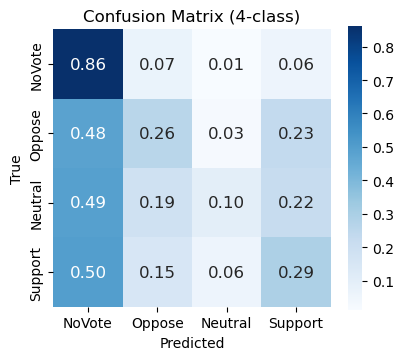

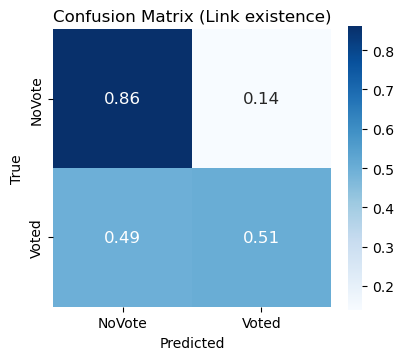

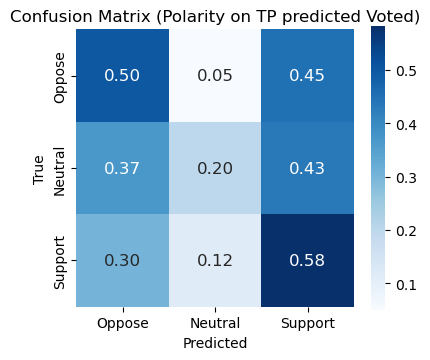

In [ ]:
# ---- 1) 4-class confusion matrix ----
labels_4 = ["NoVote", "Oppose", "Neutral", "Support"]
cm4 = confusion_matrix(y_true_4, y_pred_4, labels=[0,1,2,3])
plot_cm(cm4, labels_4, "Confusion Matrix (4-class)", normalize=True)
# plot_cm(cm4, labels_4, "Confusion Matrix (4-class) - normalized", normalize=True)

# ---- 2) Link existence confusion matrix (NoVote vs Voted) ----
y_true_link = (y_true_4 != 0).astype(int)
y_pred_link = (y_pred_4 != 0).astype(int)
cm_link = confusion_matrix(y_true_link, y_pred_link, labels=[0,1])
plot_cm(cm_link, ["NoVote", "Voted"], "Confusion Matrix (Link existence)", normalize=True)
# plot_cm(cm_link, ["NoVote", "Voted"], "Confusion Matrix (Link existence) - normalized", normalize=True)

# ---- 3) Polarity confusion matrix on TP edges where model predicts Voted ----
mask_tp = (y_true_4 != 0) & (y_pred_4 != 0)
y_true_pol = (y_true_4[mask_tp] - 1)  # {0,1,2}
y_pred_pol = (y_pred_4[mask_tp] - 1)  # {0,1,2}
cm_pol = confusion_matrix(y_true_pol, y_pred_pol, labels=[0,1,2])
plot_cm(cm_pol, ["Oppose", "Neutral", "Support"],
        "Confusion Matrix (Polarity on TP predicted Voted)", normalize=True)
# plot_cm(cm_pol, ["Oppose", "Neutral", "Support"],
#         "Confusion Matrix (Polarity on TP predicted Voted) - normalized", normalize=True)